In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/DataHacks2021/

/content/drive/MyDrive/DataHacks2021


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
def transform_data(filename, num_days):
    input_data = pd.read_csv(filename, index_col=0)
    sp500 = input_data['SP500']
    lst = [[input_data.iloc[i-num_days:i].values,sp500[i]] for i in range(num_days,len(input_data))]
    final = [[[item for sublist in x[0] for item in sublist], x[1]] for x in lst]
    return final

In [7]:
class MyDataset(Dataset):
    def __init__(self, filename, num_days, debug=False):
        self.data = transform_data(filename, num_days)
        self.num_days = num_days
        if debug:
          self.data = self.data[:128]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        result = {}
        result["input"] = torch.tensor(self.data[index][0], dtype=torch.float32).reshape(num_days, -1).permute(1,0)
        result["output"] = torch.tensor(self.data[index][1], dtype=torch.float32)
        return result

In [71]:
class Net(nn.Module):
    def __init__(self, num_features, num_days):
        super(Net, self).__init__()
        self.lstm = torch.nn.LSTM(num_days, 1, 4, dropout=0.2).cuda()
        self.conv1 = torch.nn.Conv1d(num_features, 256, 1)
        self.conv2 = torch.nn.Conv1d(256, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 1024, 1)
        self.conv4 = torch.nn.Conv1d(1024, 128, 1)
        self.conv5 = torch.nn.Conv1d(128, 16, 1)
        self.conv6 = torch.nn.Conv1d(16, 1, 1)

        self.bn1 = torch.nn.BatchNorm1d(256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.bn3 = torch.nn.BatchNorm1d(1024)
        self.bn4 = torch.nn.BatchNorm1d(128)
        self.bn5 = torch.nn.BatchNorm1d(16)

        self.drop = torch.nn.Dropout(0.2)
    def forward(self, inputs):
        x = inputs
        x = self.lstm(x)[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.drop(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.drop(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.conv6(x)
        return x.reshape(-1)

In [76]:
batch_size = 128
epochs = 300
lr = 1e-3  # scheduler will help
filename = "8_percentage_change_difference_normalized.csv"
num_days = 30
num_features = len(transform_data(filename, num_days)[0][0]) // num_days

model = Net(num_features, num_days).cuda()
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)

train_data = MyDataset(filename, num_days)
loader = DataLoader(train_data, batch_size=batch_size)

total_loss = 0
for epoch in range(epochs):
    model.train()
    for iteration, data in enumerate(loader):
        input = data["input"].cuda()
        gt = data["output"].cuda()
        optim.zero_grad()
        pred = model(input)
        loss = loss_fn(pred, gt)
        loss.backward()
        optim.step()
        total_loss += loss.item()
    print("Epoch:{}, Training loss: {}".format(epoch, total_loss / len(transform_data(filename, num_days))))
    total_loss = 0

Epoch:0, Training loss: 0.0026562051293532504
Epoch:1, Training loss: 0.001544560842405973
Epoch:2, Training loss: 0.001001774331834431
Epoch:3, Training loss: 0.0006813469123907873
Epoch:4, Training loss: 0.0005027597669839184
Epoch:5, Training loss: 0.00037593973890242427
Epoch:6, Training loss: 0.0002461410858391365
Epoch:7, Training loss: 0.00016842898477407084
Epoch:8, Training loss: 0.00010650769699227709
Epoch:9, Training loss: 7.695986298321834e-05
Epoch:10, Training loss: 4.882517128275238e-05
Epoch:11, Training loss: 3.13278372734574e-05
Epoch:12, Training loss: 3.0364568751548065e-05
Epoch:13, Training loss: 2.9421286069109995e-05
Epoch:14, Training loss: 2.6505127966024046e-05
Epoch:15, Training loss: 2.1028422708319705e-05
Epoch:16, Training loss: 2.1411568353812688e-05
Epoch:17, Training loss: 2.3457111339625656e-05
Epoch:18, Training loss: 1.9693777041652216e-05
Epoch:19, Training loss: 2.0057905799110364e-05
Epoch:20, Training loss: 1.7292514409099525e-05
Epoch:21, Trai

In [77]:
model.eval()
data = transform_data(filename, num_days)
scat = []
for i in range(len(data)):
    input = torch.tensor(data[i][0], dtype=torch.float32).reshape(1, num_days, -1).permute(0,2,1).cuda()
    gt = torch.tensor(data[i][1], dtype=torch.float32).cuda()
    pred = model(input)[0]
    scat.append([gt, pred])

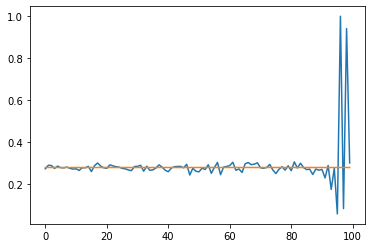

In [79]:
plt.plot(scat[:100])

In [17]:
a = torch.tensor([[[1,2,3], [4,5,6]], [[1,2,3], [4,5,6]], [[1,2,3], [4,5,6]], [[1,2,3], [4,5,6]]])
a

tensor([[[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]]])

In [18]:
a[:,:,0]

tensor([[1, 4],
        [1, 4],
        [1, 4],
        [1, 4]])